## Pre-processing function examples

This notebook contains samples call to the basic pre-processing functions. 

### Read data and imports

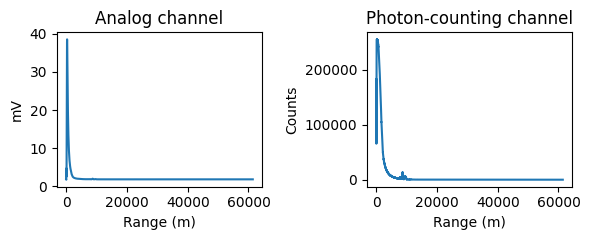

In [6]:
from importlib import reload

import numpy as np
from scipy.stats import shapiro, anderson, probplot

from matplotlib import pyplot as plt
%matplotlib inline

#from lidar_processing import fit_checks; reload(fit_checks)
#from lidar_processing import pre_processing; reload(pre_processing)

from lifa.processing import fit_checks; reload(fit_checks)
from lifa.processing import pre_processing; reload(pre_processing)

# Read input data
#f = np.loadtxt('../data/sample_profiles_532_an_ph.txt')
#C:\Users\jairo\OneDrive\Documentos\Git\lifa\tests\tests_data\processing\sample_profiles_532_an_ph.txt
f = np.loadtxt(r'..\tests\tests_data\processing\sample_profiles_532_an_ph.txt')
z = f[:, 0]
signal_an = f[:, 1]
signal_ph = f[:, 2]

#plt.plot(z, signal_an)

plt.figure(figsize=(6, 2.5))
plt.subplot(121)
plt.title('Analog channel')
plt.plot(z, signal_an)
plt.xlabel('Range (m)')
plt.ylabel('mV')

plt.subplot(122)
plt.title('Photon-counting channel')

plt.plot(z, signal_ph)
plt.xlabel('Range (m)')
plt.ylabel('Counts')

plt.tight_layout()
plt.savefig('example_channels.png', dpi=150)

### Correct dead time

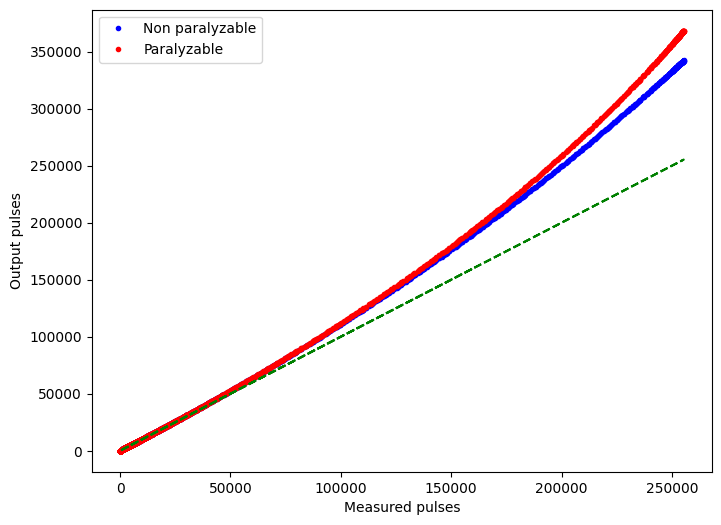

In [7]:
dead_time = 2  # ns
duration_per_file = 25 * 600  # ns
files = 134
measurement_interval = duration_per_file * files

non_paralyzable_corrected = pre_processing.correct_dead_time_nonparalyzable(signal_ph, 
                                                                            measurement_interval, 
                                                                            dead_time)
paralyzable_corrected = pre_processing.correct_dead_time_paralyzable(signal_ph, 
                                                                     measurement_interval, 
                                                                     dead_time)
plt.figure(figsize=(8, 6))
plt.plot(signal_ph, non_paralyzable_corrected, 'b.', label='Non paralyzable')
plt.plot(signal_ph, paralyzable_corrected, 'r.', label='Paralyzable')
plt.plot(signal_ph, signal_ph, 'g--')
plt.xlabel('Measured pulses'); plt.ylabel('Output pulses')
plt.legend()

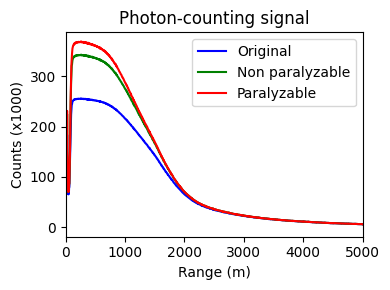

In [8]:
plt.figure(figsize=(4, 3))
plt.title('Photon-counting signal')
plt.plot(z, signal_ph/1000, 'b', label='Original')
plt.plot(z, non_paralyzable_corrected/1000, 'g', label='Non paralyzable')
plt.plot(z, paralyzable_corrected/1000, 'r', label='Paralyzable')
plt.xlabel('Range (m)'); plt.ylabel('Counts (x1000)')
plt.legend()
plt.xlim(0, 5000)
plt.tight_layout()
plt.savefig('deadtime.png', dpi=150)

### Background subtraction

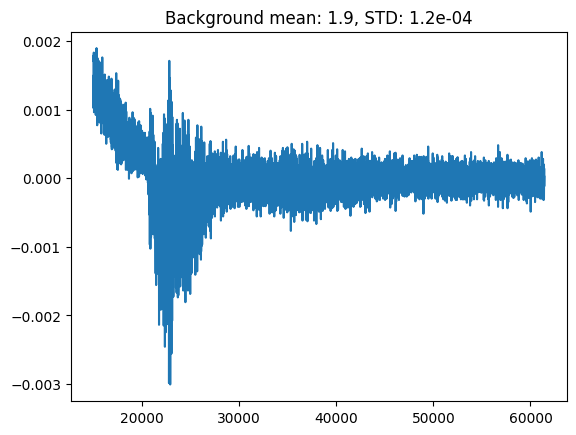

In [9]:
# Background subtracted analog
backround_removed_analog, background_mean, background_std = \
        pre_processing.subtract_background(signal_an, idx_min=14000, idx_max=16000)

idx_min = 4000

plt.plot(z[idx_min:], backround_removed_analog[idx_min:])
plt.title('Background mean: %2.1f, STD: %2.1e' % (background_mean, background_std))

# Background subtracted photon
backround_removed_photon, _, _= \
        pre_processing.subtract_background(non_paralyzable_corrected, idx_min=14000, idx_max=16000)

### Trigger delay

Text(0.5, 1.0, 'Background corrected signal')

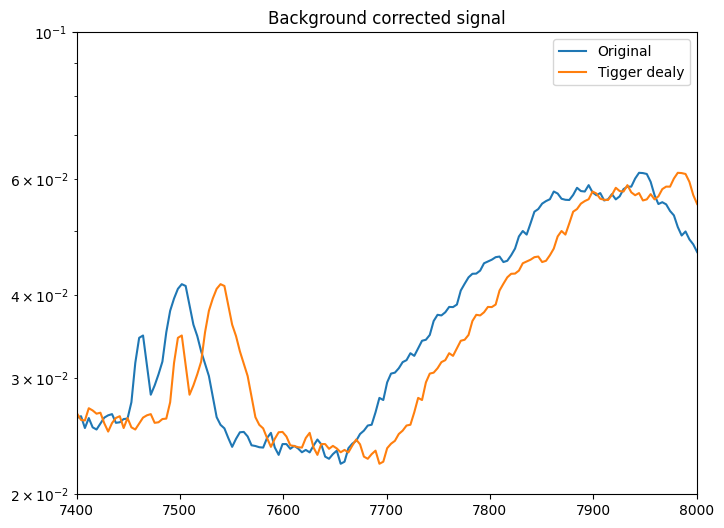

In [10]:
# Integer bin shift
trigger_delay_bin = 10
trigger_delay_analog = pre_processing.correct_trigger_delay_bins(backround_removed_analog, trigger_delay_bin)

idx_max = 4000

plt.figure(figsize=(8, 6))

plt.plot(z[:idx_max], backround_removed_analog[:idx_max], label='Original')
plt.plot(z[:idx_max], trigger_delay_analog[:idx_max], label='Tigger dealy')
plt.legend()
plt.xlim(7400, 8000)
plt.ylim(0.02, 0.1)
plt.yscale('log')
plt.title("Background corrected signal")
                                          

Text(0.5, 1.0, 'Background corrected signal')

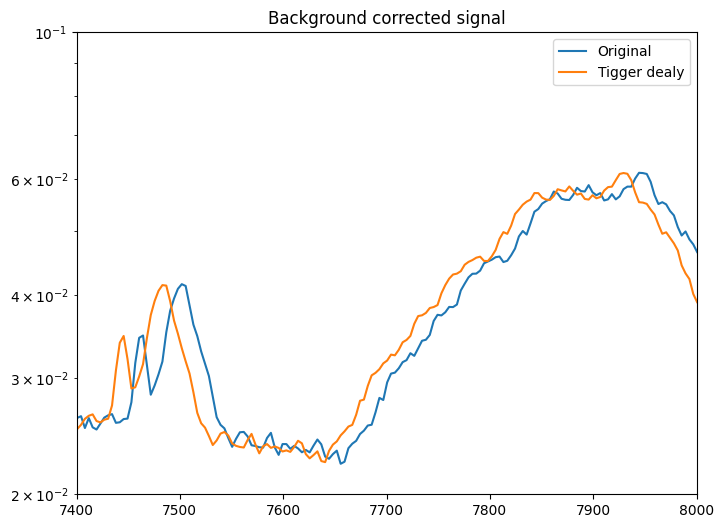

In [11]:
# Ns shift (fractional bins)
trigger_delay_ns = -120
trigger_delay_analog = pre_processing.correct_trigger_delay_ns(backround_removed_analog, 
                                                                         z, 
                                                                         trigger_delay_ns)
range_corrected_analog_td = pre_processing.apply_range_correction(trigger_delay_analog, z)

idx_max = 4000

plt.figure(figsize=(8, 6))
plt.plot(z[:idx_max], backround_removed_analog[:idx_max], label='Original')
plt.plot(z[:idx_max], trigger_delay_analog[:idx_max], label='Tigger dealy')
plt.legend()
plt.xlim(7400, 8000)
plt.ylim(0.02, 0.1)
plt.yscale('log')
plt.title("Background corrected signal")


### Trigger delay

(7400.0, 10500.0)

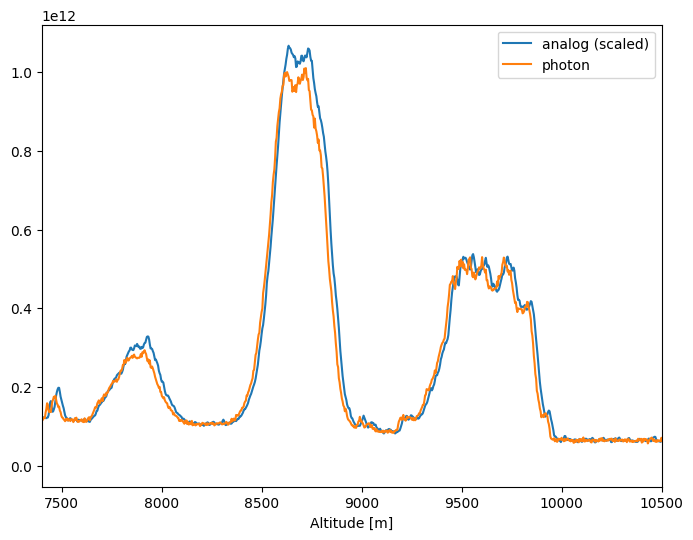

In [12]:
# Apply the correcte trigger delay
trigger_delay_ns = -120
trigger_delay_analog = pre_processing.correct_trigger_delay_ns(backround_removed_analog, 
                                                                         z, 
                                                                         trigger_delay_ns)

range_corrected_analog = pre_processing.apply_range_correction(trigger_delay_analog, z)
range_corrected_photon = pre_processing.apply_range_correction(backround_removed_photon, z)

scale_factor = np.sum(range_corrected_photon[1000:1500]) / np.sum(range_corrected_analog[1000:1500])

idx_max = 4000

plt.figure(figsize=(8, 6))
plt.plot(z[:idx_max], range_corrected_analog[:idx_max] * scale_factor, label='analog (scaled)')
plt.plot(z[:idx_max], range_corrected_photon[:idx_max], label='photon')
plt.legend()
plt.xlabel('Altitude [m]')
#plt.ylim(0.1e12, 1.5e12)
plt.xlim(7400, 10500)

### Gluing

In [19]:
window_length = 500
correlation_threshold = 0.9
intercept_threshold = 5
gaussian_threshold = 0.1
minmax_threshold = 0.5
min_idx = 100  # 100 * 3.75 = 375,
max_idx = 4000  # 4000 * 3.75 = 15000


glued_signal, gluing_std, gluing_central_idx, score, c_lower, c_upper = pre_processing.glue_signals_1d(range_corrected_analog, 
                                                                       range_corrected_photon, 
                                                                       window_length,
                                                                       correlation_threshold, 
                                                                       intercept_threshold, 
                                                                       gaussian_threshold,
                                                                       minmax_threshold, 
                                                                       min_idx, max_idx)


In [20]:
glued_signal

array([ 6.05015455e+05,  3.76326610e+06,  4.32806745e+06, ...,
        3.33434428e+09, -4.37591896e+08, -4.37645332e+08], shape=(16380,))

In [21]:
#%timeit pre_processing.glue_signals(range_corrected_analog,range_corrected_photon, window_length, correlation_threshold, intercept_threshold, gaussian_threshold, minmax_threshold, min_idx, max_idx)

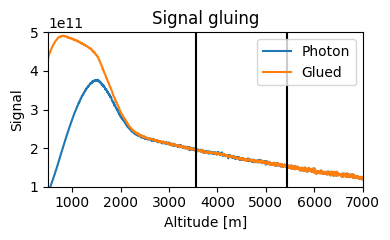

In [22]:
plt.figure(figsize=(4, 2.5))
plt.plot(z, range_corrected_photon, label='Photon')
plt.plot(z, glued_signal, label='Glued')
plt.xlabel('Altitude [m]')
plt.ylabel('Signal')

ylims = plt.ylim()
plt.vlines([z[gluing_central_idx - window_length//2], z[gluing_central_idx + window_length//2]], ylims[0], ylims[1], 'k')
plt.ylim(ylims)

plt.xlim(1000, 11000)
plt.xlim(500, 7000); plt.ylim(0.1e12, 0.5e12)
plt.legend()

plt.title('Signal gluing')
plt.tight_layout()
plt.savefig('gluing.png', dpi=150)

In [25]:
gluing_central_idx - window_length/2

np.float64(949.0)

NameError: name 'idx' is not defined

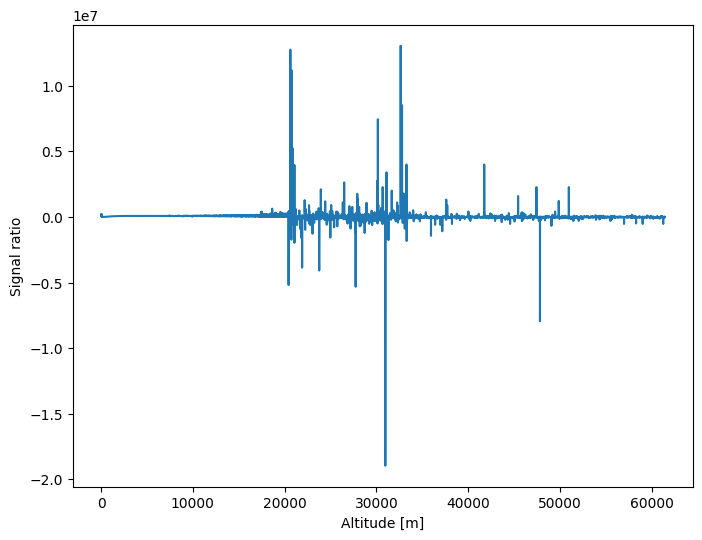

In [26]:
signal_ratio = range_corrected_photon / range_corrected_analog

plt.figure(figsize=(8, 6))
plt.plot(z, signal_ratio, label='Signal ratio')
plt.xlabel('Altitude [m]')
plt.ylabel('Signal ratio')

ylims = (0, np.max(signal_ratio[0:3000]))
plt.vlines([z[idx - window_length/2], z[idx + window_length/2]], ylims[0], ylims[1])
plt.ylim(ylims)

plt.xlim(0, 15000)
plt.legend()

### Analysis of the gluing region

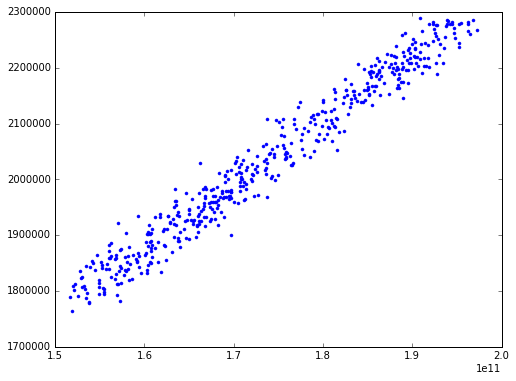

In [38]:
idx_min = idx - window_length/2
idx_max = idx + window_length/2

plt.figure(figsize=(8, 6))
plt.plot(range_corrected_photon[idx_min:idx_max],  range_corrected_analog[idx_min:idx_max], '.')

In [39]:
gluing_score = pre_processing.get_gluing_score(range_corrected_analog, 
                                               range_corrected_photon, 
                                               window_length)

gluing_candidates = pre_processing.get_gluing_candidates(range_corrected_analog,
                                                         range_corrected_photon, 
                                                         window_length,
                                                         correlation_threshold, 
                                                         intercept_threshold, 
                                                         gaussian_threshold,
                                                         minmax_threshold)

gluing_score_masked = np.ma.masked_where(~gluing_candidates, gluing_score,)

In [40]:
correlation_score = fit_checks.sliding_check_correlation(range_corrected_analog, 
                                              range_corrected_photon, 
                                              window_length)

intercept_score= fit_checks.sliding_check_linear_fit_intercept(range_corrected_analog, 
                                                    range_corrected_photon,
                                                    window_length)

not_gaussian_score = fit_checks.sliding_check_residuals_not_gaussian(range_corrected_analog, 
                                                          range_corrected_photon,
                                                          window_length)

minmax_score = fit_checks.sliding_check_min_max_ratio(range_corrected_analog, 
                                                      range_corrected_photon,
                                                      window_length)

dagostino_score = fit_checks.sliding_check_residuals_not_gaussian_dagostino(range_corrected_analog,
                                                      range_corrected_photon,
                                                      window_length)

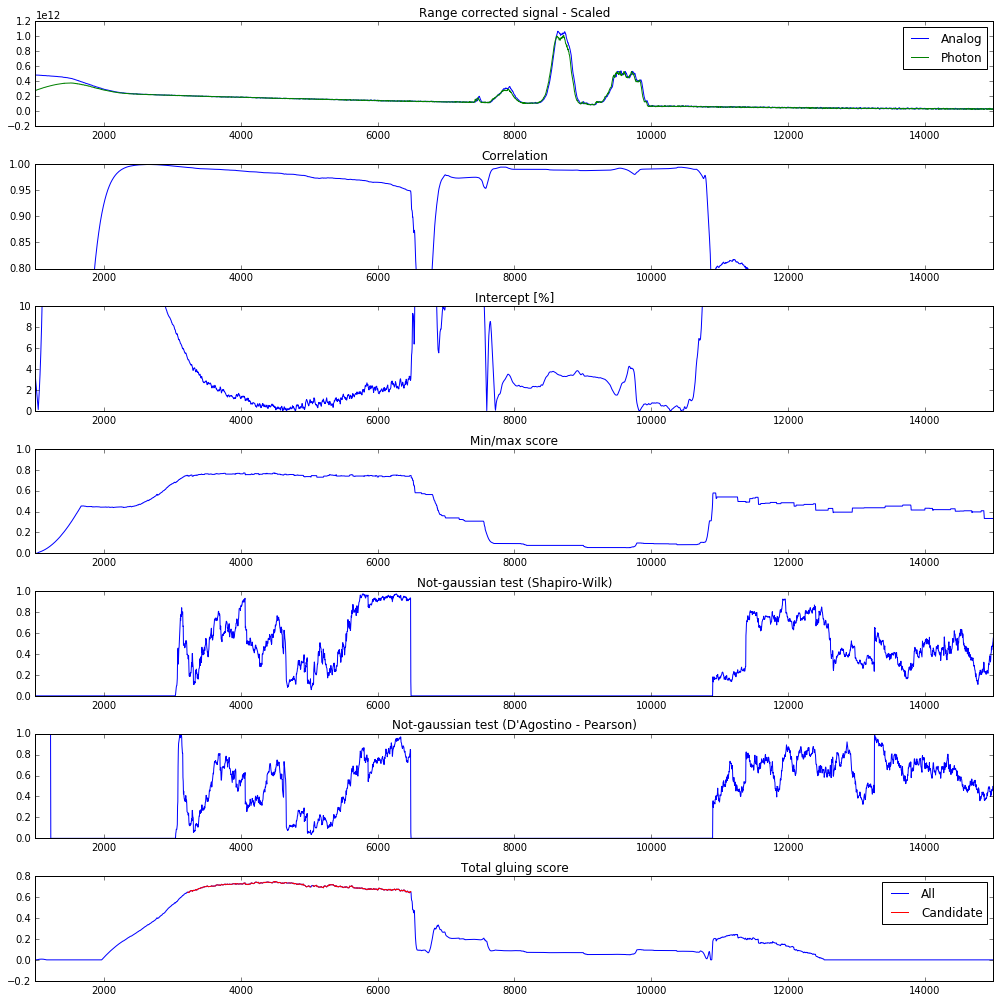

In [44]:
plt.figure(figsize=(14, 14))

ax1 = plt.subplot(711)
plt.plot(z, range_corrected_analog * c_lower, label = "Analog")
plt.plot(z, range_corrected_photon * c_upper, label = "Photon")
plt.legend()
plt.title('Range corrected signal - Scaled')

plt.subplot(712, sharex=ax1)
plt.plot(z, correlation_score)
plt.ylim(0.8, 1)
plt.title('Correlation')

plt.subplot(713, sharex=ax1)
plt.plot(z, intercept_score)
plt.ylim(0, 10)
plt.title('Intercept [%]')

plt.subplot(714, sharex=ax1)
plt.plot(z, minmax_score)
plt.title('Min/max score')
plt.ylim(0, 1)

plt.subplot(715, sharex=ax1)
plt.plot(z, not_gaussian_score)
plt.title('Not-gaussian test (Shapiro-Wilk)')

plt.subplot(716, sharex=ax1)
plt.plot(z, dagostino_score)
plt.title("Not-gaussian test (D'Agostino - Pearson)")
plt.ylim(0, 1)

plt.subplot(717, sharex=ax1)
plt.plot(z, gluing_score, label='All')
plt.plot(z, gluing_score_masked, 'r', label='Candidate')
plt.title('Total gluing score')
plt.legend()

plt.xlim(1000, 15000)
plt.tight_layout()